## Download dataset & import libraries



In [ ]:
import gdown

file_id_1 = '0BxYys69jI14kYVM3aVhKS1VhRUk'
output_file_1 = 'UTKFace.tar.gz'
gdown.download(f'https://drive.google.com/uc?id={file_id_1}', output_file_1)

!tar -xvf UTKFace.tar.gz

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /content/UTKFace.tar.gz
100%|██████████| 107M/107M [00:02<00:00, 44.6MB/s] 


Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

In [ ]:
import pandas as pd
import numpy as np
import os
import csv
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from PIL import Image

## Put data into .csv file

In [ ]:
DIR = 'UTKFace/'
os.listdir(DIR)

count = 0
for path in os.listdir(DIR):
    if os.path.isfile(os.path.join(DIR, path)):
        count += 1
print('File count:', count)

File count: 23708


In [ ]:
DIR = 'UTKFace/'

# limiting size of pictures depending on RAM (google turn off the GPU after a while)
max_photos = 23708
photos_processed = 0

list_of_pictures = []

for name in tqdm(os.listdir(DIR)):
    if os.path.isfile(os.path.join(DIR, name)):
        list_of_pictures.append(name)
        photos_processed += 1
        if photos_processed >= max_photos:
            break

gender = []
age = []


for picture in tqdm(list_of_pictures):
    picture_splitted = str.split(picture, '_')
    age.append(picture_splitted[0])
    gender.append(picture_splitted[1])

age_gender_data = list(zip(age, gender))
data = list(zip(list_of_pictures, age,gender))

csv_file = 'path_age_gender_data.csv'


with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ImagePath', 'Age', 'Gender'])
    writer.writerows(data)

del gender
del age
del list_of_pictures
print(f"Data saved to {csv_file}")

  0%|          | 0/23708 [00:00<?, ?it/s]

  0%|          | 0/23708 [00:00<?, ?it/s]

Data saved to path_age_gender_data.csv


## Split data for training and test, and preprocess images dataset

In [ ]:
def preprocess_images(images_path):
    arr_of_images = []
    for image in tqdm(images_path):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        arr_of_images.append(img)
    return np.array(arr_of_images)

def preprocess_image(image_path):
    img = load_img(image_path, grayscale=True)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = np.array(img)
    img  = img / 255.0

    return img

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('path_age_gender_data.csv')

images_train, images_test, age_train, age_test, gender_train, gender_test = train_test_split(df['ImagePath'], df['Age'], df['Gender'], test_size=0.2, random_state=42)


In [ ]:
print(images_train.shape)
print(age_train.shape)
print(gender_train.shape)

print(images_test.shape)
print(age_test.shape)
print(gender_test.shape)

(18966,)
(18966,)
(18966,)
(4742,)
(4742,)
(4742,)


In [ ]:
x_train = preprocess_images(DIR + images_train)
x_test =  preprocess_images(DIR + images_test)

  0%|          | 0/18966 [00:00<?, ?it/s]

  0%|          | 0/4742 [00:00<?, ?it/s]

In [ ]:
print(x_train.shape)
print(x_test.shape)

(18966, 128, 128)
(4742, 128, 128)


In [ ]:
x_test = x_test / 255.0
x_train = x_train / 255.0

In [ ]:
y_gender_train = np.array(gender_train)
y_gender_test = np.array(gender_test)
y_age_train = np.array(age_train)
y_age_test = np.array(age_test)

## Models

In [ ]:
## ITERACIJA 1

input_shape = (128, 128, 1)

inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

flatten = Flatten() (maxp_3)

dense_1 = Dense(512, activation='relu') (flatten)
dense_2 = Dense(512, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

gender_output = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
age_output = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[gender_output, age_output])

model.compile(optimizer='adam',
              loss=['binary_crossentropy', 'mae'],
              metrics=['accuracy'])

In [ ]:
# ITERACIJA 2
input_shape = (128, 128, 1)

inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

flatten = Flatten() (maxp_3)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.5) (dense_1)
dropout_2 = Dropout(0.5) (dense_2)

gender_output = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
age_output = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[gender_output, age_output])

model.compile(optimizer='adam',
              loss=['binary_crossentropy', 'mae'],
              metrics=['accuracy'])

In [ ]:
# ITERACIJA 3
input_shape = (128, 128, 1)

inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(512, activation='relu') (flatten)
dense_2 = Dense(512, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

gender_output = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
age_output = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[gender_output, age_output])

model.compile(optimizer='adam',
              loss=['binary_crossentropy', 'mae'],
              metrics=['accuracy'])

In [ ]:
#KONAČNA ITERACIJA
input_shape = (128, 128, 1)

inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)
conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu') (maxp_4)
maxp_5 = MaxPooling2D(pool_size=(2, 2)) (conv_5)

flatten = Flatten() (maxp_5)

dense_1 = Dense(512, activation='relu') (flatten)
dense_2 = Dense(512, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

gender_output = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
age_output = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[gender_output, age_output])

model.compile(optimizer='adam',
              loss=['binary_crossentropy', 'mae'],
              metrics=['accuracy'])

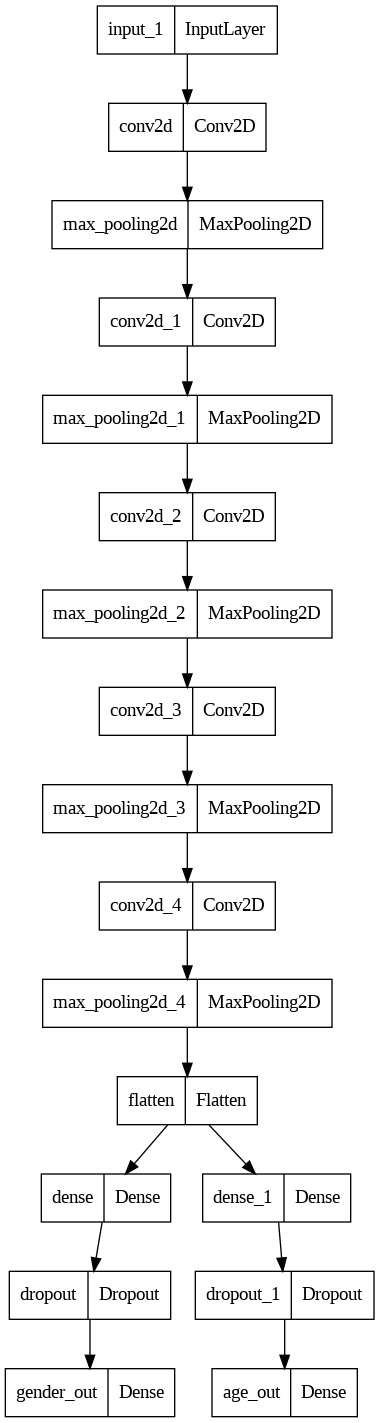

In [ ]:
plot_model(model)

## Train and test

In [ ]:
history = model.fit(x=x_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=12, validation_split=0.2)

Epoch 1/12
475/475 [==============================] - 21s 26ms/step - loss: 16.1953 - gender_out_loss: 0.7226 - age_out_loss: 15.4727 - gender_out_accuracy: 0.5117 - age_out_accuracy: 0.0475 - val_loss: 15.1416 - val_gender_out_loss: 0.6897 - val_age_out_loss: 14.4519 - val_gender_out_accuracy: 0.5258 - val_age_out_accuracy: 0.0482
Epoch 2/12
475/475 [==============================] - 11s 23ms/step - loss: 13.4177 - gender_out_loss: 0.6488 - age_out_loss: 12.7689 - gender_out_accuracy: 0.6138 - age_out_accuracy: 0.0448 - val_loss: 11.5209 - val_gender_out_loss: 0.5538 - val_age_out_loss: 10.9671 - val_gender_out_accuracy: 0.7243 - val_age_out_accuracy: 0.0482
Epoch 3/12
475/475 [==============================] - 11s 23ms/step - loss: 10.2342 - gender_out_loss: 0.5318 - age_out_loss: 9.7024 - gender_out_accuracy: 0.7414 - age_out_accuracy: 0.0464 - val_loss: 9.1527 - val_gender_out_loss: 0.4765 - val_age_out_loss: 8.6762 - val_gender_out_accuracy: 0.7657 - val_age_out_accuracy: 0.0482
E

In [ ]:
test_metrics = model.evaluate(x=x_test, y=[y_gender_test, y_age_test])

print("Test Metrics (loss,gender_out_loss, age_out_loss, gender_out_accuracy, gender_out_accuracy):\n", test_metrics)

149/149 [==============================] - 1s 10ms/step - loss: 7.1206 - gender_out_loss: 0.2982 - age_out_loss: 6.8224 - gender_out_accuracy: 0.8648 - age_out_accuracy: 0.0456
Test Metrics (loss,gender_out_loss, age_out_loss, gender_out_accuracy, gender_out_accuracy):
 [7.120584011077881, 0.2982046604156494, 6.8223795890808105, 0.8648249506950378, 0.045550402253866196]


## Plot results into graphs

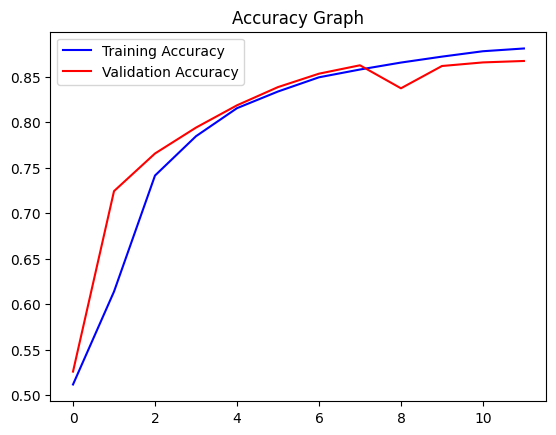

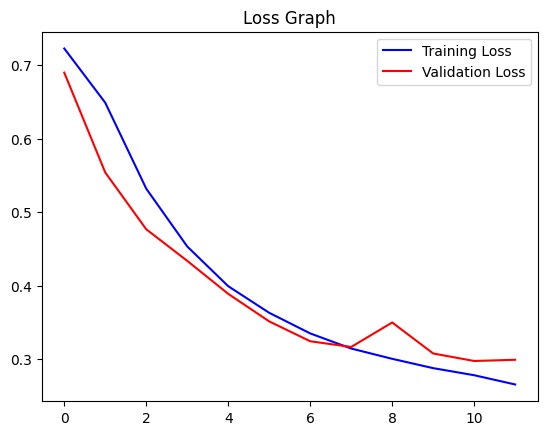

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

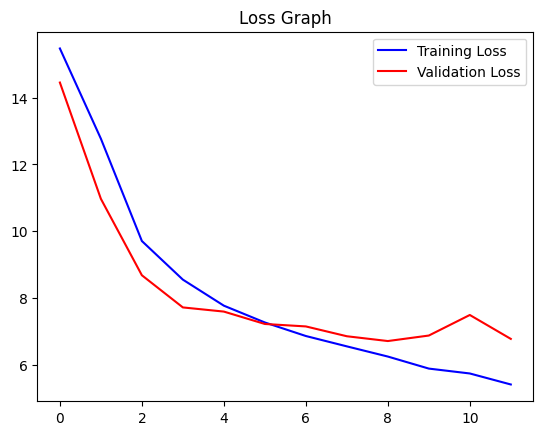

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


## Try to predict with a random images

In [ ]:
gender_dict = {0:'Male', 1:'Female'}

Original Gender: Female Original Age: 8
1/1 [==============================] - 0s 122ms/step
Predicted Gender: Female Predicted Age: 3


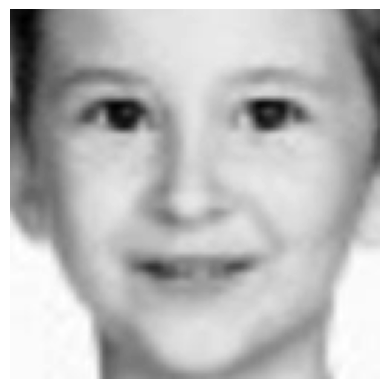

In [ ]:
image_index = 999
print("Original Gender:", gender_dict[y_gender_test[image_index]], "Original Age:", y_age_test[image_index])

pred = model.predict(x_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(x_test[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 20
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: 24


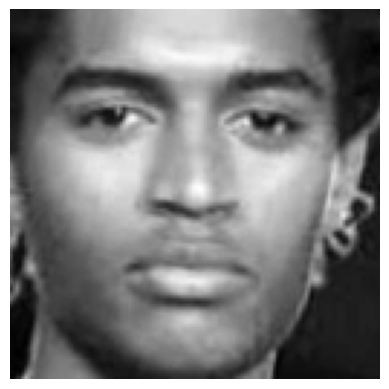

In [ ]:
image_index = 4500
print("Original Gender:", gender_dict[y_gender_test[image_index]], "Original Age:", y_age_test[image_index])

pred = model.predict(x_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(x_test[image_index].reshape(128, 128), cmap='gray');

1/1 [==============================] - 0s 83ms/step
Predicted Gender: Male Predicted Age: 25


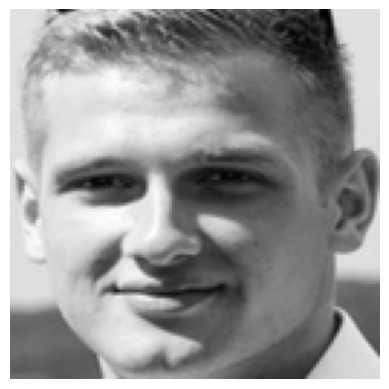

In [ ]:
image_path = 'me.png'
img = preprocess_image(image_path)

pred = model.predict(img.reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(img.reshape(128, 128), cmap='gray');

## Save model

In [ ]:
model.save('/content/drive/MyDrive/age-gender-prediction-v2-01-23708-pictures.h5')